# **LAB 3: BINARY CLASSIFICATION WITH NEURAL NETWORKS**
# Trishal Srivastava (ACE079BCT076)

# A. Objective:
The goal of this assignment is to build and train neural networks using PyTorch to solve a non-linear binary classification problem. We will compare simple linear models against non-linear models (using ReLU activation) to demonstrate why non-linearity is essential for classifying complex geometric data.


# B. Dataset and Problem Statement:
We are using the Circles Dataset. It consists of 1,000 data points on a 2D plane. Each point has two coordinates (X1 and X2) and a label (0 or 1). Label 1 represents the inner circle; the group of data points located in the center of the graph, forming a small circular cluster whereas Label 0 represents the outer ring; the group of data points surrounding the center, forming a larger ring shape.

The problem is that these two groups are not separated by a straight line. Because the data is shaped like one circle inside another, a simple straight line cannot divide them. This makes it a great way to test if a neural network can learn to recognize more complicated shapes and patterns.


# C. Background and Theory:

### Neural Networks
A neural network is a computational model inspired by the way biological neurons process information. It consists of layers of interconnected nodes that learn to identify patterns by mapping input data (features) to a target output (prediction).

### Activation Function
An activation function is a mathematical function that decides whether a neuron should fire or not by transforming the layer's output before it passes to the next part of the network.

### Linear vs. Non-Linear Separability

Linear Transformations: Neural network layers perform linear transformations using weights and biases to calculate a weighted sum of inputs (y=mx+b).

Limitation: If a dataset is linearly separable, a single straight line can divide the classes. However, if a model only uses linear layers, it can only create straight line boundaries. No matter how many linear layers are stacked together, they mathematically collapse into a single linear function, which cannot solve complex shapes like concentric circles.

Non-Linearity (The Solution): To handle complex data, we must introduce Activation Functions like ReLU (Rectified Linear Unit). ReLU acts as a filter that turns negative numbers to zero ($f(x) = \max(0, x)$). This simple operation allows the network to bend its decision boundary. By stacking many of these small bends, the network can approximate curves and wrap around specific data clusters, such as the inner circle in our datase


### The PyTorch Training Loop
The process of teaching a network involves a repetitive cycle called the training loop, which consists of five fundamental steps:

1. Forward Pass: The model processes the input data to produce a guess, known as a raw logit.

2. Loss Calculation: A loss function (such as BCEWithLogitsLoss) measures the mathematical distance between the model's guess and the actual label.

3. Zeroing the optimizer gradients: We must manually clear the optimizer's gradients before each update. This is necessary because PyTorch is designed to accumulate gradients by default; if they are not reset to zero, the model will add new gradients to old ones, leading to incorrect calculations and preventing the model from learning properly.

4. Backpropagation: The system calculates the gradient of the loss with respect to the model's weights. This identifies exactly how each weight contributed to the error.

5. Optimizer Step: An optimization algorithm (like SGD or Adam) uses those gradients to adjust the model's weights, slightly improving the accuracy for the next pass.

## 1. Data Retrieval & Inspection

First, we import the required libraries and load the file using pandas.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Load CSV with pandas
df = pd.read_csv("circles_binary_classification.csv")

# Show head and describe
print("First 5 rows:")
print(df.head())
print("\nDescription:")
print(df.describe())

First 5 rows:
         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0

Description:
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000


## 2. Data Cleaning & Feature Design
We convert the data into NumPy arrays and then into PyTorch tensors.

In [50]:
import torch

# Create X and y
X = df[['X1', 'X2']].values
y = df['label'].values

# Convert to tensors
# Standard type for features is float32
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X dtype: {X.dtype}, y dtype: {y.dtype}")

X shape: torch.Size([1000, 2]), y shape: torch.Size([1000])
X dtype: torch.float32, y dtype: torch.float32


The dataset consists of 1,000 points where each point has two coordinates (X1, X2) used to determine its position on a 2D map.

The goal is to use these coordinates to classify whether a point belongs to the inner circle or the outer ring (Label 0 or 1).

## 3. Visualize Data

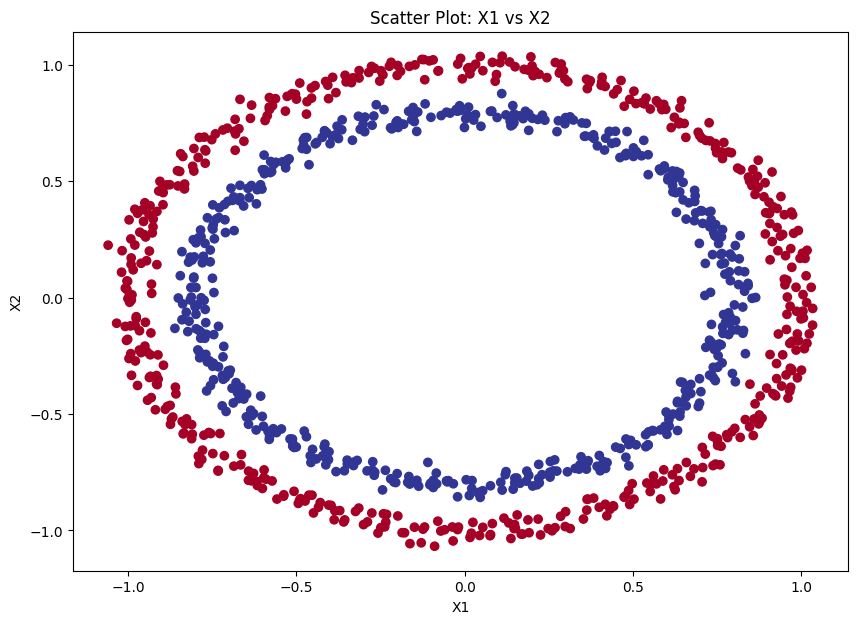

In [51]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("Scatter Plot: X1 vs X2")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

## 4. Train/Test split

In [52]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Move tensors to device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

Using device: cuda


## 5. Helper Functions (Plotting & Training)
We define a reusable function to plot decision boundaries and a standard training loop to avoid code repetition.

In [53]:
# HELPER: Plot Decision Boundary
def plot_decision_boundary(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))
    
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)
    
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))
    
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# HELPER: Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # Count how many match
    acc = (correct / len(y_pred)) * 100 
    return acc


# HELPER: Training Loop 
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.1):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    train_loss_values = []
    test_loss_values = []
    epoch_count = []
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        
        # 1. Forward pass
        y_logits = model(X_train).squeeze()
        
        # 2. Calculate Loss
        loss = loss_fn(y_logits, y_train)
        
        # 3. Zero gradients
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        model.eval()
        with torch.inference_mode():
            # Training Accuracy (Updated Weights)
            train_logits = model(X_train).squeeze()
            train_pred = torch.round(torch.sigmoid(train_logits))
            acc = accuracy_fn(y_train, train_pred)

            # Testing Accuracy
            test_logits = model(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_acc = accuracy_fn(y_test, test_pred)
            
        # Print stats
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
            
        train_loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        epoch_count.append(epoch)

    return epoch_count, train_loss_values, test_loss_values

## 6. Implement and Train Models
### 6.1. ModelV0: Linear (2 -> 5 -> 1)
This model has no activation functions, making it a linear classifier. It is expected to fail on circular data.

In [54]:
import torch.nn as nn

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))


# Move all data to the gpu and ensure they are the correct data type
X_train, y_train = X_train.to(device).to(torch.float), y_train.to(device).to(torch.float)
X_test, y_test = X_test.to(device).to(torch.float), y_test.to(device).to(torch.float)

model_0 = CircleModelV0().to(device)
# Call training loop
print("\nTraining Model V0...")
epochs_v0, train_loss_v0, test_loss_v0 = train_model(model_0, X_train, y_train, X_test, y_test, epochs=100)


Training Model V0...
Epoch: 0 | Loss: 0.70763, Acc: 50.62% | Test Loss: 0.72428, Test Acc: 46.50%
Epoch: 10 | Loss: 0.70284, Acc: 50.25% | Test Loss: 0.71660, Test Acc: 46.50%
Epoch: 20 | Loss: 0.69979, Acc: 50.38% | Test Loss: 0.71144, Test Acc: 47.00%
Epoch: 30 | Loss: 0.69776, Acc: 50.12% | Test Loss: 0.70778, Test Acc: 46.50%
Epoch: 40 | Loss: 0.69636, Acc: 50.38% | Test Loss: 0.70509, Test Acc: 46.50%
Epoch: 50 | Loss: 0.69539, Acc: 50.00% | Test Loss: 0.70306, Test Acc: 46.50%
Epoch: 60 | Loss: 0.69471, Acc: 50.50% | Test Loss: 0.70150, Test Acc: 46.50%
Epoch: 70 | Loss: 0.69423, Acc: 50.75% | Test Loss: 0.70029, Test Acc: 46.50%
Epoch: 80 | Loss: 0.69389, Acc: 50.38% | Test Loss: 0.69933, Test Acc: 46.50%
Epoch: 90 | Loss: 0.69365, Acc: 50.12% | Test Loss: 0.69858, Test Acc: 45.50%


### 6.2. ModelV1: Deeper Linear (2 -> 15 -> 15 -> 1)
Still no activation functions. Even with more layers, it remains a linear transformation.

In [55]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=15)
        self.layer_2 = nn.Linear(in_features=15, out_features=15)
        self.layer_3 = nn.Linear(in_features=15, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
print("\nTraining Model V1...")
epochs_v1, train_loss_v1, test_loss_v1 = train_model(model_1, X_train, y_train, X_test, y_test, epochs=1000)


Training Model V1...
Epoch: 0 | Loss: 0.69588, Acc: 50.00% | Test Loss: 0.69540, Test Acc: 50.00%


Epoch: 10 | Loss: 0.69357, Acc: 50.00% | Test Loss: 0.69407, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69313, Acc: 54.12% | Test Loss: 0.69402, Test Acc: 51.50%
Epoch: 30 | Loss: 0.69304, Acc: 52.25% | Test Loss: 0.69413, Test Acc: 49.00%
Epoch: 40 | Loss: 0.69301, Acc: 51.50% | Test Loss: 0.69424, Test Acc: 48.00%
Epoch: 50 | Loss: 0.69300, Acc: 51.00% | Test Loss: 0.69432, Test Acc: 47.00%
Epoch: 60 | Loss: 0.69299, Acc: 50.88% | Test Loss: 0.69439, Test Acc: 47.00%
Epoch: 70 | Loss: 0.69299, Acc: 51.00% | Test Loss: 0.69444, Test Acc: 47.00%
Epoch: 80 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69449, Test Acc: 47.00%
Epoch: 90 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69452, Test Acc: 47.00%
Epoch: 100 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69455, Test Acc: 46.50%
Epoch: 110 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69458, Test Acc: 46.50%
Epoch: 120 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69460, Test Acc: 46.00%
Epoch: 130 | Loss: 0.69298, Acc: 51.25% | Test Loss: 0.69461,

### 6.3. ModelV2: Non-Linear (2 -> 64 -> 64 -> 10 -> 1 with ReLU)
This model introduces ReLU, allowing it to learn non-linear patterns (curves).

In [56]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=10)
        self.layer_4 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # 2 -> 64 -> ReLU -> 64 -> ReLU -> 10 -> ReLU -> 1
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_2 = CircleModelV2().to(device)
print("\nTraining Model V2...")
# Training for 1500 epochs to ensure convergence
epochs_v2, train_loss_v2, test_loss_v2 = train_model(model_2, X_train, y_train, X_test, y_test, epochs=1500)


Training Model V2...
Epoch: 0 | Loss: 0.69615, Acc: 50.00% | Test Loss: 0.69561, Test Acc: 50.00%
Epoch: 10 | Loss: 0.69370, Acc: 50.00% | Test Loss: 0.69363, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69244, Acc: 57.75% | Test Loss: 0.69263, Test Acc: 56.50%
Epoch: 30 | Loss: 0.69172, Acc: 52.00% | Test Loss: 0.69210, Test Acc: 53.00%
Epoch: 40 | Loss: 0.69116, Acc: 51.75% | Test Loss: 0.69174, Test Acc: 51.00%
Epoch: 50 | Loss: 0.69066, Acc: 52.38% | Test Loss: 0.69144, Test Acc: 53.50%
Epoch: 60 | Loss: 0.69018, Acc: 53.00% | Test Loss: 0.69112, Test Acc: 53.50%
Epoch: 70 | Loss: 0.68961, Acc: 53.87% | Test Loss: 0.69072, Test Acc: 54.00%
Epoch: 80 | Loss: 0.68914, Acc: 54.50% | Test Loss: 0.69041, Test Acc: 53.50%
Epoch: 90 | Loss: 0.68866, Acc: 55.38% | Test Loss: 0.69007, Test Acc: 53.50%
Epoch: 100 | Loss: 0.68815, Acc: 57.12% | Test Loss: 0.68971, Test Acc: 54.50%
Epoch: 110 | Loss: 0.68760, Acc: 59.13% | Test Loss: 0.68933, Test Acc: 55.00%
Epoch: 120 | Loss: 0.68702, Acc: 60.25% |

## 7. Evaluation & Plots
We plot the decision boundaries and loss curves for all models to compare them.

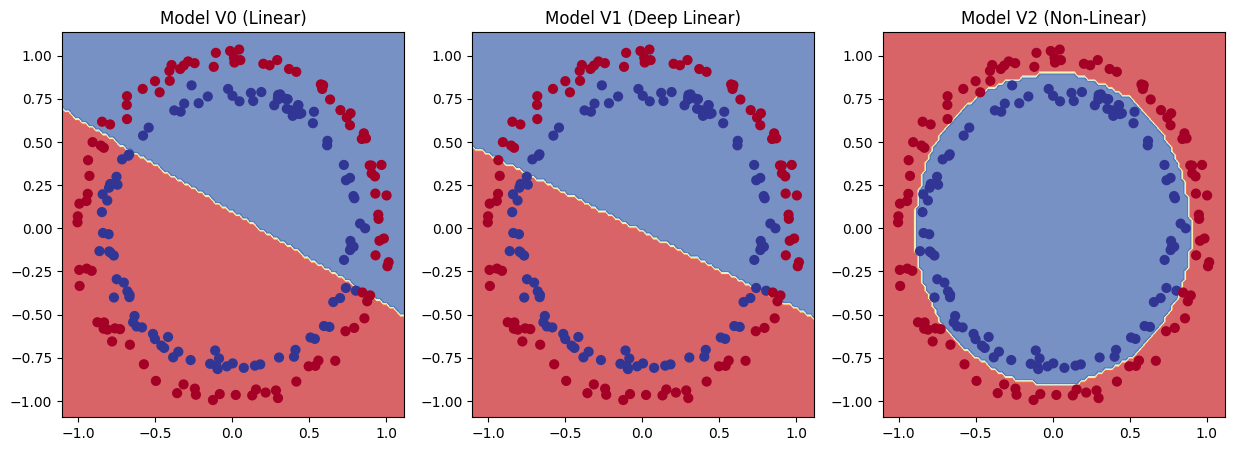

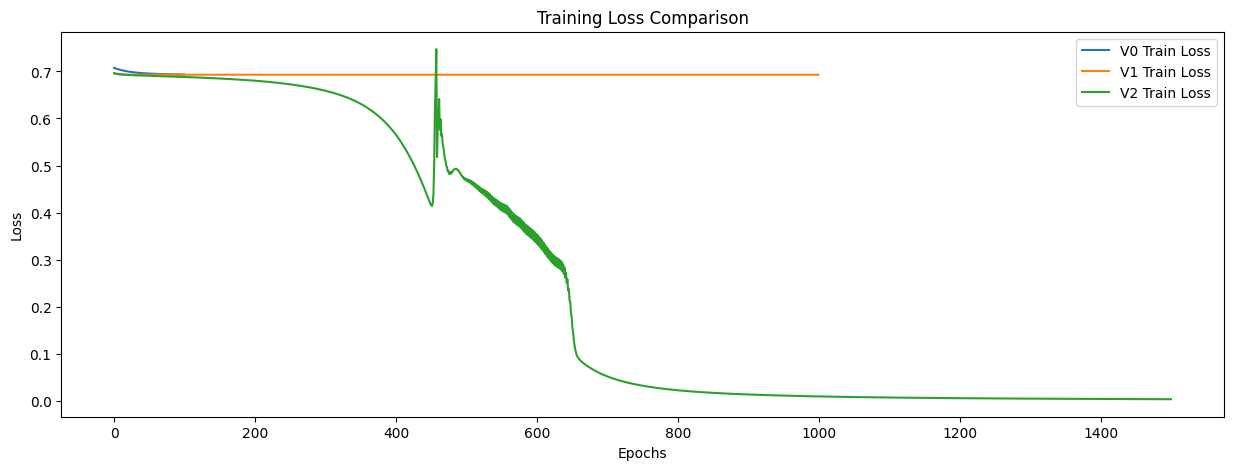

In [57]:
# Plot Decision Boundaries
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Model V0 (Linear)")
plot_decision_boundary(model_0, X_test, y_test)

plt.subplot(1, 3, 2)
plt.title("Model V1 (Deep Linear)")
plot_decision_boundary(model_1, X_test, y_test)

plt.subplot(1, 3, 3)
plt.title("Model V2 (Non-Linear)")
plot_decision_boundary(model_2, X_test, y_test)
plt.show()

# Plot Loss Curves
plt.figure(figsize=(15, 5))
plt.title("Training Loss Comparison")
plt.plot(epochs_v0, train_loss_v0, label="V0 Train Loss")
plt.plot(epochs_v1, train_loss_v1, label="V1 Train Loss")
plt.plot(epochs_v2, train_loss_v2, label="V2 Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 8. Discussion and Conclusion
### Findings:

Model V0 (Linear): This model performed poorly (45.5% accuracy). Visualizing the decision boundary shows a straight line trying to separate two concentric circles, which is geometrically impossible.

Model V1 (Deep Linear): Despite having more layers and neurons, this model also failed (46% accuracy). This demonstrates a fundamental concept in deep learning that stacking linear layers without non-linear activation functions is mathematically equivalent to a single linear layer. It cannot learn curved boundaries.

Model V2 (Non-Linear): This model achieved very high accuracy (100%). The ReLU activation function introduced non-linearity, allowing the neural network to approximate the circular boundary. The decision boundary plot clearly shows the model wrapping around the inner circle.

### Conclusion:
For datasets with non-linear relationships (like the circles dataset), a simple linear regression or a neural network without activation functions is insufficient. Introducing non-linear activation functions (like ReLU or Tanh) and sufficient hidden units allows the network to learn complex patterns and successfully classify the data.

==============================================================================================
## Optional Extra Credit: Optimizer Comparison (Adam vs. SGD)

In this section, we investigate the impact of the optimizer on model convergence. The optimizer is responsible for updating the model's weights based on the gradients calculated during backpropagation.

We will compare two popular optimizers on the same non-linear model architecture (ModelV2):
1.  SGD (Stochastic Gradient Descent): Updates weights using a fixed learning rate based on the current batch's gradient.
2.  Adam (Adaptive Moment Estimation): Adapts the learning rate for each parameter individually and uses momentum (moving averages of past gradients) to accelerate convergence.

Hypothesis:
We expect Adam to converge faster (reach a lower loss in fewer epochs) than SGD because of its ability to adapt learning rates and navigate the loss landscape more efficiently.

Running SGD Experiment...
Running Adam Experiment...


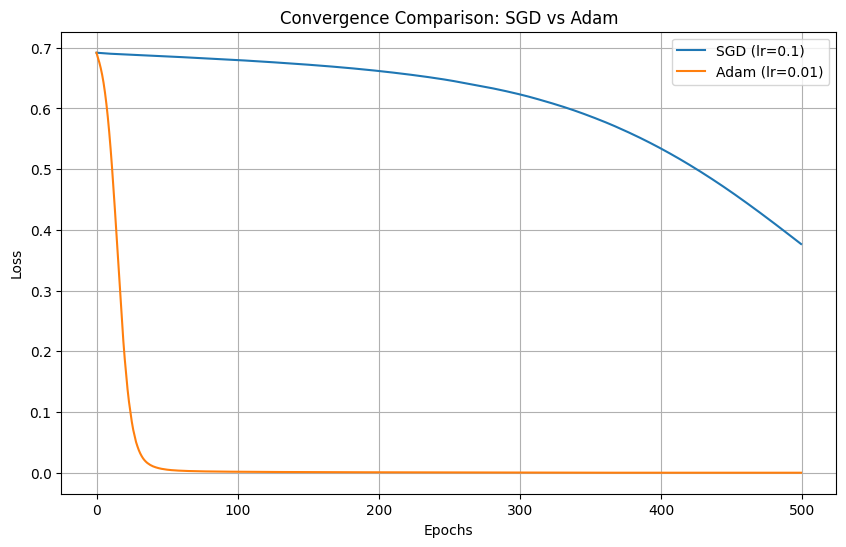

In [58]:
import matplotlib.pyplot as plt
import torch
from torch import nn

# 1. Setup Data and Device (Reuse previous setup)
device = "cuda" if torch.cuda.is_available() else "cpu"
# Assumes X_train, y_train, X_test, y_test are already created and on device

# 2. Define the Non-Linear Model (ModelV2)
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

# 3. Helper to Run an Experiment
def run_experiment(optimizer_name, learning_rate, epochs=500):
    # Re-seed for fairness so both models start with same random weights
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    # Create a fresh model
    model = CircleModelV2().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    
    # Select Optimizer
    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
    # Track losses
    loss_curve = []
    
    # Training Loop
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        y_logits = model(X_train).squeeze()
        loss = loss_fn(y_logits, y_train)
        
        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_curve.append(loss.item())
        
    return loss_curve

# 4. Run COmparision

print("Running SGD Experiment...")
sgd_losses = run_experiment("SGD", learning_rate=0.1, epochs=500)

print("Running Adam Experiment...")
# Adam is usually more efficient, so we often use a lower LR (e.g., 0.01)
adam_losses = run_experiment("Adam", learning_rate=0.01, epochs=500) 

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(sgd_losses, label="SGD (lr=0.1)")
plt.plot(adam_losses, label="Adam (lr=0.01)")
plt.title("Convergence Comparison: SGD vs Adam")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion: Optimizer Comparison
### Observation
The convergence plot demonstrates a dramatic difference in efficiency. Adam (Orange Line) reached near-zero loss in under 50 epochs, while SGD (Blue Line) was still struggling at a loss of ~0.38 after 500 epochs.

### Reasoning
The huge difference in speed in the graph happens because Adam is much smarter than SGD.

1. Adaptive learning rates: SGD treats every single parameter the same way and takes small, careful steps. Adam looks at each parameter individually and decides how big of a step to take. If a parameter needs to change a lot, Adam speeds it up.

2. Momentum: Adam keeps track of where it was going in previous steps. It acts like a ball rolling down a hill that picks up speed as it goes. SGD does not do this. It stops to check the slope from scratch at every single step, which makes it much slower and more hesitant.

Because of these, Adam was able to solve the problem in under 50 epochs while SGD was still computing after 500 epochs.

### Conclusion
This assignment confirmed that non-linear activation functions (ReLU) are essential for classifying complex data like concentric circles. Furthermore, using modern optimizers like Adam can reduce training time by orders of magnitude compared to traditional SGD.